# Dog breed

This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.


**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.

In [2]:
!pip install smdebug
!pip install torchvision --no-cache-dir  

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes


In [29]:
import json
import sagemaker
from sagemaker import get_execution_role
from sagemaker.session import Session
from sagemaker.pytorch import PyTorch, PyTorchModel
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.debugger import DebuggerHookConfig, ProfilerConfig, FrameworkProfile
from sagemaker.debugger import Rule, ProfilerRule, rule_configs
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot

import boto3
import os
import numpy as np

from PIL import Image
import IPython

session = sagemaker.Session()

bucket = session.default_bucket()
print("Default Bucket: {}".format(bucket))

region = session.boto_region_name
print("AWS Region: {}".format(region))

role = get_execution_role()
print("RoleArn: {}".format(role))

prefix = "dog_breed_project"

Default Bucket: sagemaker-us-east-1-678049007427
AWS Region: us-east-1
RoleArn: arn:aws:iam::678049007427:role/service-role/AmazonSageMaker-ExecutionRole-20211130T135410


## Dataset
For this project, I decided to use the dog breed classification dataset which contains images from 133 dog breeds divided into training, testing, and validation datasets.

In [8]:
# Note: I cleared the output of the 2 following cells as they were too voluminous

In [ ]:
# Fetch and upload the data to AWS S3
# Command to download and unzip data
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip

In [ ]:
# Import to S3
os.environ["PREFIX"] = prefix
os.environ["DEFAULT_S3_BUCKET"] = bucket
!aws s3 sync ./dogImages s3://${DEFAULT_S3_BUCKET}/${PREFIX}/

## Quick inspection

Let's have a look at 2 random images.

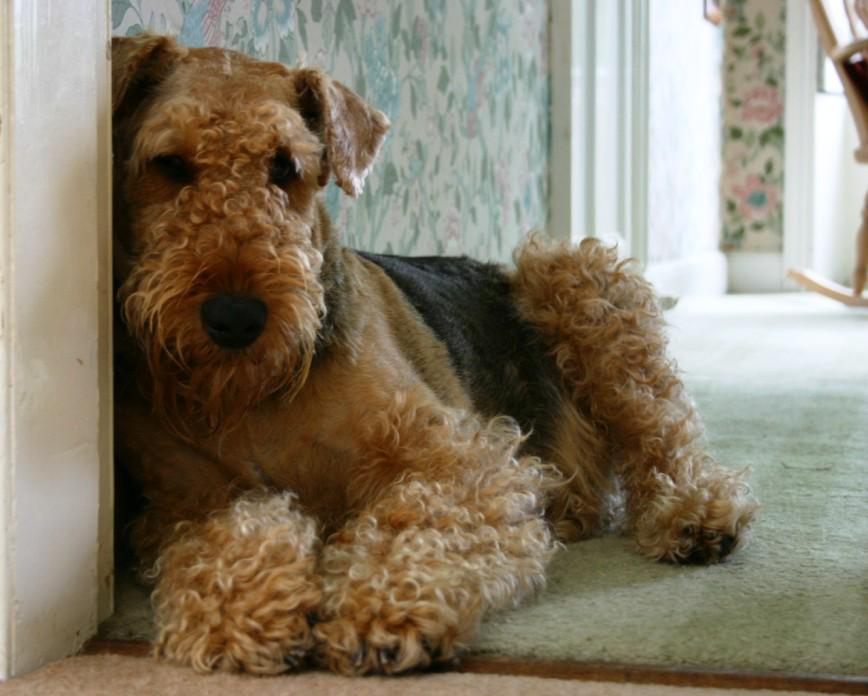

Image shape:  (696, 868, 3)


In [5]:
image1 = Image.open('images/Airedale_terrier_00173.jpg')
display(image1)
print("Image shape: ", np.array(image1).shape)

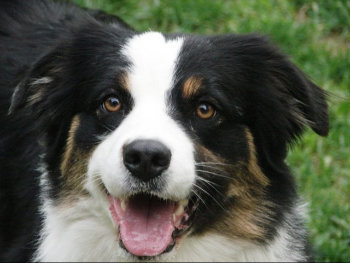

Image shape:  (263, 350, 3)


In [6]:
image2 = Image.open('images/Australian_shepherd_00818.jpg')
display(image2)
print("Image shape: ", np.array(image2).shape)

Two interesting things:  
- The shape of the images can vary.
- The RGB channel is in the last dimension. (Maybe it is specific to the Image.open function and it won't matter for the training as we will be using Pytorch loader. However it might be relevant when we will want to perform individual inference).

## Hyperparameter Tuning
This is the part where we will finetune a pretrained model with hyperparameter tuning. 

We will use the `hpo.py` script to perform hyperparameter tuning.

I implemented my training in a slighty different way than in the exercises:  

- At the end of each epoch, the loss and accuracy is calculated on the entire validation set. I then use those metrics to keep track of the best performing model (model weights), which will be saved a the end of the training.
- Once the training is done, the model is evaluated against the test dataset. It is on this metric that the hyperparameter job will focus. 

In [14]:
# I will simply try with those 2 hyperparameters as they are propably the most influencial (between those which don't change the model architecture)
hyperparameter_ranges = {
    "lr": ContinuousParameter(0.001, 0.1),
    "batch-size": CategoricalParameter([16, 32, 64]), 
}

In [15]:
estimator = PyTorch(
    entry_point="scripts/hpo.py",
    role=role,
    py_version='py36',
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.g4dn.2xlarge",
    output_path = 's3://{}/{}/hyperparameter_tuning'.format(bucket, prefix)  # The training jobs output (mainly model artefacts) will go there.
)

objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": objective_metric_name, "Regex": "Test set: Average loss: ([0-9\\.]+)"}]

tuner = HyperparameterTuner(estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=4,
    max_parallel_jobs=2,
    objective_type=objective_type,
)

In [16]:
# Fit the HP Tuner
tuner.fit({"train": "s3://{}/{}".format(bucket, prefix)})

...................................................................................................................................................................................................................................................................................................................................!


In [17]:
# Get the best estimators and the best HPs
best_estimator = tuner.best_estimator()

# Get the hyperparameters of the best trained model
best_estimator.hyperparameters()


2021-12-05 21:35:58 Starting - Preparing the instances for training
2021-12-05 21:35:58 Downloading - Downloading input data
2021-12-05 21:35:58 Training - Training image download completed. Training in progress.
2021-12-05 21:35:58 Uploading - Uploading generated training model
2021-12-05 21:35:58 Completed - Training job completed


{'_tuning_objective_metric': '"average test loss"',
 'batch-size': '"16"',
 'lr': '0.005139186423487383',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2021-12-05-21-10-47-697"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-678049007427/pytorch-training-2021-12-05-21-10-47-697/source/sourcedir.tar.gz"'}

## Model Profiling and Debugging
Using the best hyperparameters, create and finetune a new model

We will need to use the `train_model.py` script to perform model profiling and debugging.

In [23]:
# Set up debugging and profiling rules and hooks
rules = [
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization())
    #Rule.sagemaker(base_config=rule_configs.loss_not_decreasing(),rule_parameters={"tensor_regex": "CrossEntropyLoss_output_0", "mode": "TRAIN"})
]

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, 
    framework_profile_params=FrameworkProfile(num_steps=1))

debugger_config = DebuggerHookConfig(
    hook_parameters={"train.save_interval": "10", "eval.save_interval": "10"})

In [24]:
# Create and fit an estimator
estimator = PyTorch(
    entry_point="scripts/train_model.py",
    role=role,
    py_version='py36',
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.g4dn.2xlarge",
    profiler_config=profiler_config,      # profiler hook
    debugger_hook_config=debugger_config, # debugger hook
    output_path = 's3://{}/{}/main_training'.format(bucket, prefix),  # The training jobs output (mainly model artefacts) will go there.
    hyperparameters={                                                 # Best values from the previous hpo
        "batch-size": 16,
        "lr": 0.005}
)

estimator.fit({"train": "s3://{}/{}".format(bucket, prefix)})

2021-12-05 22:14:41 Starting - Starting the training job...
2021-12-05 22:14:51 Starting - Launching requested ML instancesProfilerReport-1638742481: InProgress
......
2021-12-05 22:15:56 Starting - Preparing the instances for training.........
2021-12-05 22:17:33 Downloading - Downloading input data.........
2021-12-05 22:19:14 Training - Downloading the training image.........
2021-12-05 22:20:38 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2021-12-05 22:20:38,836 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2021-12-05 22:20:38,855 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2021-12-05 22:20:41,873 sagemaker_pytorch_container.training INFO     Invoking user training script.
2021-12-05 22:20:42,199 sagemaker-training-toolkit INFO     Invoking user script
Training

In [ ]:
# Plot a debugging output.

In [25]:
trial = create_trial(estimator.latest_job_debugger_artifacts_path())
print(trial.tensor_names())

[2021-12-05 22:27:07.940 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:18 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-678049007427/dog_breed_project/main_training/pytorch-training-2021-12-05-22-14-41-524/debug-output
[2021-12-05 22:27:10.231 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:18 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2021-12-05 22:27:11.256 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:18 INFO trial.py:210] Loaded all steps
['CrossEntropyLoss_output_0']


In [26]:
print(len(trial.tensor('CrossEntropyLoss_output_0').steps(mode=ModeKeys.TRAIN)))
print(len(trial.tensor('CrossEntropyLoss_output_0').steps(mode=ModeKeys.EVAL)))

42
100


In [27]:
# Set up functions to plot the output tensors
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

def plot_tensor(trial, tensor_name):
    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


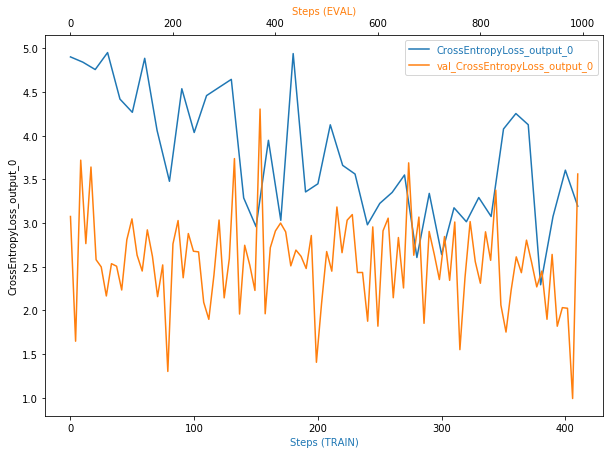

In [28]:
plot_tensor(trial, "CrossEntropyLoss_output_0")

**NOTE**: 
- Firstly, the profiler-report states "NoIssuesFound".
- Training loss: I do think it is normal for the loss to be bit bumpy when evaluated on each batch, especially when it is quite small (batch_size = 16).
- Validation loss: I can't explain the strange shape of the val_crossentropyloss_output, especially when we can clearly see that the val loss is decreasing properly at each epoch (output of the estimator.fit() cell).

Also:  
I think differencing dog breeds requires to focus on very specific features. If I had to aim for a performing model, I will consider finetuning some of the last CNN layers of the model, not just the classification ones.

In [ ]:
# Display the profiler output

In [29]:
rule_output_path = estimator.output_path + "/" + estimator.latest_training_job.job_name + "/rule-output"
print(f"You will find the profiler report in {rule_output_path}")

You will find the profiler report in s3://sagemaker-us-east-1-678049007427/dog_breed_project/main_training/pytorch-training-2021-12-05-22-14-41-524/rule-output


In [30]:
! aws s3 ls {rule_output_path} --recursive

2021-12-05 22:25:53     389105 dog_breed_project/main_training/pytorch-training-2021-12-05-22-14-41-524/rule-output/ProfilerReport-1638742481/profiler-output/profiler-report.html
2021-12-05 22:25:52     239184 dog_breed_project/main_training/pytorch-training-2021-12-05-22-14-41-524/rule-output/ProfilerReport-1638742481/profiler-output/profiler-report.ipynb
2021-12-05 22:25:47        191 dog_breed_project/main_training/pytorch-training-2021-12-05-22-14-41-524/rule-output/ProfilerReport-1638742481/profiler-output/profiler-reports/BatchSize.json
2021-12-05 22:25:47      22242 dog_breed_project/main_training/pytorch-training-2021-12-05-22-14-41-524/rule-output/ProfilerReport-1638742481/profiler-output/profiler-reports/CPUBottleneck.json
2021-12-05 22:25:47       2186 dog_breed_project/main_training/pytorch-training-2021-12-05-22-14-41-524/rule-output/ProfilerReport-1638742481/profiler-output/profiler-reports/Dataloader.json
2021-12-05 22:25:47        129 dog_breed_project/main_training/pyt

In [31]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-678049007427/dog_breed_project/main_training/pytorch-training-2021-12-05-22-14-41-524/rule-output/ProfilerReport-1638742481/profiler-output/profiler-reports/MaxInitializationTime.json to ProfilerReport-1638742481/profiler-output/profiler-reports/MaxInitializationTime.json
download: s3://sagemaker-us-east-1-678049007427/dog_breed_project/main_training/pytorch-training-2021-12-05-22-14-41-524/rule-output/ProfilerReport-1638742481/profiler-output/profiler-reports/CPUBottleneck.json to ProfilerReport-1638742481/profiler-output/profiler-reports/CPUBottleneck.json
download: s3://sagemaker-us-east-1-678049007427/dog_breed_project/main_training/pytorch-training-2021-12-05-22-14-41-524/rule-output/ProfilerReport-1638742481/profiler-output/profiler-reports/GPUMemoryIncrease.json to ProfilerReport-1638742481/profiler-output/profiler-reports/GPUMemoryIncrease.json
download: s3://sagemaker-us-east-1-678049007427/dog_breed_project/main_training/pytorch-training-202

In [32]:
# Get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [33]:
IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

No rules have been triggered, seems like everything went fine!

## Model Deploying

In [6]:
# Deploy your model to an endpoint
# I had a break during this project, I therefore need to instantiate a new estimator. 
estimator = PyTorch.attach("pytorch-training-2021-12-05-22-14-41-524") # Previous training job
predictor = estimator.deploy(initial_instance_count=1, instance_type='ml.c5.large') 


2021-12-05 22:26:36 Starting - Preparing the instances for training
2021-12-05 22:26:36 Downloading - Downloading input data
2021-12-05 22:26:36 Training - Training image download completed. Training in progress.
2021-12-05 22:26:36 Uploading - Uploading generated training model
2021-12-05 22:26:36 Completed - Training job completed
------!

From there, I did not managed to perform any inference.   
I always get the same error message: 

ModelError: An error occurred (ModelError) when calling the InvokeEndpoint operation: Received server error (0) from primary with message "Your invocation timed out while waiting for a response from container primary. Review the latency metrics for each container in Amazon CloudWatch, resolve the issue, and try again.". See https://us-east-1.console.aws.amazon.com/cloudwatch/home?region=us-east-1#logEventViewer:group=/aws/sagemaker/Endpoints/pytorch-training-2021-12-05-23-20-02-170 in account 678049007427 for more information.

  
The cloudwatch log did not help either: "W-9000-model_1 org.pytorch.serve.wlm.BatchAggregator - Load model failed: model, error: Worker died."  

The solution I found, is to provide my own inference script.   
Disclaimer: I created this script to receive raw images only. For it to receive numpy arrays, a few adjustements would be necessary.

In [48]:
model_artifact = "s3://sagemaker-us-east-1-678049007427/dog_breed_project/main_training/pytorch-training-2021-12-05-22-14-41-524/output/model.tar.gz"

model = PyTorchModel(model_data=model_artifact, 
                             role=role, 
                             entry_point="scripts/predict_jpeg.py",
                             py_version="py36",
                             framework_version="1.8") 

In [49]:
predictor = model.deploy(initial_instance_count=1, instance_type='ml.c5.large') 
endpoint_name = predictor.endpoint_name

------!

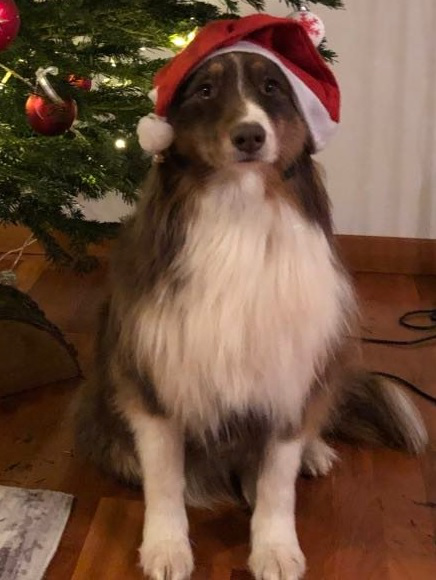

Image shape:  (580, 436, 3)


In [50]:
# I will be working with a personal image, an Australian shepherd
image_test = Image.open('images/lolo.jpg')
display(image_test)
print("Image shape: ", np.array(image_test).shape)

In [51]:
# Inference as it would be performed within a Lambda function
with open("images/lolo.jpg", "rb") as f:
        image_data = f.read()

runtime = boto3.Session().client('sagemaker-runtime')

response = runtime.invoke_endpoint(EndpointName = endpoint_name,      # The name of the endpoint we created
                                   ContentType = 'image/png',         # The data format that is expected
                                   Body = image_data)  

predictions = json.loads(response['Body'].read().decode())

In [52]:
print(predictions)

[[-12.261555671691895, -5.421926498413086, -17.15594482421875, -7.225859642028809, -5.038168430328369, -1.8471126556396484, -14.301695823669434, -10.463430404663086, -18.598121643066406, -8.030734062194824, -12.380423545837402, 0.2814788222312927, -14.386855125427246, -11.623391151428223, -9.141160011291504, -10.761070251464844, -5.894889831542969, -21.63351821899414, -13.763360023498535, -20.848533630371094, -12.749175071716309, -7.973662853240967, -1.6304124593734741, -6.698840618133545, -22.305620193481445, -17.016921997070312, -19.2825927734375, -14.842506408691406, -0.45211291313171387, -11.068093299865723, -1.880217432975769, -12.331758499145508, -13.340357780456543, -13.192737579345703, -17.025300979614258, -9.2591552734375, -6.2291693687438965, -7.4758734703063965, -12.653096199035645, -11.940681457519531, -15.760231971740723, -11.201799392700195, -4.319388389587402, -16.705921173095703, -3.489333152770996, 0.8026299476623535, -33.24062728881836, -1.8033417463302612, -3.0580410

In [53]:
np.argmax(predictions[0])

114

114 == Otterhound!

That is not quite right! But we haven't really train the model so it is not suprising.